In [2]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(latex2exp))


In [3]:
annot.tbl <- '/oak/stanford/groups/mrivas/private_data/ukbb/variant_filtering/variant_filter_table.tsv.gz'

IOP_file <- '/oak/stanford/groups/mrivas/projects/ANGPTL7/ukbb_gwas/white_british/ukb24983_v2_hg19.INI2005254.genotyped.glm.linear.gz'


In [4]:
IOP <- fread(
    cmd=paste0('zcat ', IOP_file, ' | sed -e "s/#//g"'), sep='\t', data.table=F
)


In [5]:
annot.arr <- fread(
    cmd=paste0('zcat ', annot.tbl),
    sep='\t', data.table=FALSE
) %>% mutate(
    MAF=pmin(freq, 1-freq)
) %>%
mutate(
    variant = paste(CHROM, POS, REF, ALT, sep=':'),
    is_outside_of_MHC = (as.numeric(CHROM) == 6 & as.numeric(POS) < 25477797) | ( as.numeric(CHROM) == 6 & 36448354 < as.numeric(POS)) | as.numeric(CHROM) != 6
)


In [6]:
annot.arr$Csq[
    !(annot.arr$Consequence %in% c("frameshift_variant","splice_donor_variant","stop_gained","stop_lost","start_lost","splice_acceptor_variant","splice_region_variant","missense_variant","inframe_insertion","inframe_deletion"))
] = "non-coding"
annot.arr$Csq[
    annot.arr$Consequence %in% c("splice_region_variant","missense_variant","inframe_insertion","inframe_deletion")
] = "protein-altering"
annot.arr$Csq[
    annot.arr$Consequence %in% c("frameshift_variant","splice_donor_variant","stop_gained","stop_lost","start_lost","splice_acceptor_variant")
] = "protein-truncating"


In [7]:
annot.arr %>% colnames()

[1] "CHROM"             "POS"               "REF"              
 [4] "ALT"               "ID"                "Gene"             
 [7] "Consequence"       "HGVSp"             "LoF"              
[10] "LoF_filter"        "LoF_flags"         "LoF_info"         
[13] "consequence_field" "f_miss"            "f_miss_bileve"    
[16] "f_miss_wcsg"       "freq"              "hwe_p"            
[19] "maf"               "ld_indep"          "wcsg_only"        
[22] "bileve_only"       "filter"            "missingness"      
[25] "hwe"               "mcpi"              "gnomad_af"        
[28] "mgi"               "mgi_notes"         "all_filters"      
[31] "Gene_symbol"       "MAF"               "variant"          
[34] "is_outside_of_MHC" "Csq"

In [8]:
annot.arr %>% mutate(
    Csq2 = if_else(Csq == 'non-coding', 'non-coding', 'PTVs+protein-altering')
) %>% filter(0.0001 < MAF, MAF < 0.01) %>% count(is_outside_of_MHC, Csq2)


is_outside_of_MHC,Csq2,n
<lgl>,<chr>,<int>
FALSE,non-coding,857
FALSE,PTVs+protein-altering,631
TRUE,non-coding,34599
TRUE,PTVs+protein-altering,41637


## ANGPTL7

In [9]:
annot.arr %>% filter(Gene_symbol == 'ANGPTL7')

CHROM,POS,REF,ALT,ID,Gene,Consequence,HGVSp,LoF,LoF_filter,⋯,mcpi,gnomad_af,mgi,mgi_notes,all_filters,Gene_symbol,MAF,variant,is_outside_of_MHC,Csq
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<lgl>,<chr>
1,11252357,A,G,rs200058074,ENSG00000171819,missense_variant,ENSP00000366015.3:p.Gln136Arg,,,⋯,0,,,,0,ANGPTL7,5.355845e-04,1:11252357:A:G,TRUE,protein-altering
1,11252369,G,A,rs28991002,ENSG00000171819,missense_variant,ENSP00000366015.3:p.Arg140His,,,⋯,0,,,,0,ANGPTL7,2.532551e-03,1:11252369:G:A,TRUE,protein-altering
1,11253684,G,T,rs28991009,ENSG00000171819,missense_variant,ENSP00000366015.3:p.Gln175His,,,⋯,0,,,,0,ANGPTL7,8.116199e-03,1:11253684:G:T,TRUE,protein-altering
1,11253688,C,T,rs143435072,ENSG00000171819,stop_gained,ENSP00000366015.3:p.Arg177Ter,HC,,⋯,0,PASS,,,0,ANGPTL7,4.063244e-04,1:11253688:C:T,TRUE,protein-truncating
1,11255013,GGCAT,G,Affx-89021330,ENSG00000171819,frameshift_variant,ENSP00000366015.3:p.His326AspfsTer11,HC,,⋯,0,,,,0,ANGPTL7,1.483913e-05,1:11255013:GGCAT:G,TRUE,protein-truncating


In [10]:
df <- annot.arr %>% filter(Gene_symbol == 'ANGPTL7') %>%
select(variant, ID, Consequence, HGVSp, freq, MAF, ld_indep) %>%
left_join(
    IOP, by='ID'
) %>%
rename(
    variant_ID = ID
) %>%
arrange(CHROM, POS) %>%
select(-CHROM, -POS, -REF, -ALT, -A1, -TEST, -OBS_CT)

In [16]:
df %>% 
# filter(P < .05) %>%
mutate(
    BETA_CI_l = BETA - 1.96 * SE,
    BETA_CI_u = BETA + 1.96 * SE,
    MAF_percent = MAF * 100,
    BETA_str = sprintf('%.3f [%.3f, %.3f]', BETA, BETA_CI_l, BETA_CI_u)
) %>% 
select(variant, variant_ID, HGVSp, MAF_percent, BETA, BETA_CI_l, BETA_CI_u, BETA_str, P)

variant,variant_ID,HGVSp,MAF_percent,BETA,BETA_CI_l,BETA_CI_u,BETA_str,P
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1:11252357:A:G,rs200058074,ENSP00000366015.3:p.Gln136Arg,0.053558447,0.0124077,-0.2033883,0.22820370,"0.012 [-0.203, 0.228]",9.10273e-01
1:11252369:G:A,rs28991002,ENSP00000366015.3:p.Arg140His,0.253255077,-0.0714483,-0.1647267,0.02183006,"-0.071 [-0.165, 0.022]",1.33283e-01
1:11253684:G:T,rs28991009,ENSP00000366015.3:p.Gln175His,0.811619854,-0.1551680,-0.2074377,-0.10289833,"-0.155 [-0.207, -0.103]",5.96170e-09
1:11253688:C:T,rs143435072,ENSP00000366015.3:p.Arg177Ter,0.040632442,-0.1285460,-0.3736401,0.11654808,"-0.129 [-0.374, 0.117]",3.03964e-01
1:11255013:GGCAT:G,Affx-89021330,ENSP00000366015.3:p.His326AspfsTer11,0.001483913,0.2893800,-0.8244351,1.40319508,"0.289 [-0.824, 1.403]",6.10594e-01


## Hits

In [11]:
IOP_hits <- IOP %>% filter(as.numeric(P) <= 0.0001) %>% 
select(-REF, -ALT, -A1, -TEST, -OBS_CT, -T_STAT) %>%
left_join(annot.arr %>% select(-CHROM, -POS), by='ID') %>% 
arrange(as.numeric(CHROM), as.numeric(POS)) %>%
select(-CHROM, -POS) %>%
rename(variant_ID = ID) %>%
select(variant, variant_ID, BETA, SE, P, Csq, Consequence, Gene_symbol, HGVSp, MAF, ld_indep)


## qq-plot

In [12]:
IOP_anno <- annot.arr %>% filter(Csq != 'non-coding', is_outside_of_MHC) %>% select(-CHROM, -POS, -REF, -ALT) %>%
inner_join(IOP, by='ID')

In [13]:
qq_p_obs <- IOP_anno %>% 
filter(
    1e-4 < as.numeric(maf),
    as.numeric(maf) < 1e-2
) %>% 
mutate(log10P = -log10(P)) %>% arrange(-log10P) %>% select(log10P) %>% drop_na() %>% pull() 
qq_p_exp <- -(qq_p_obs %>% length() %>% ppoints() %>% log10())

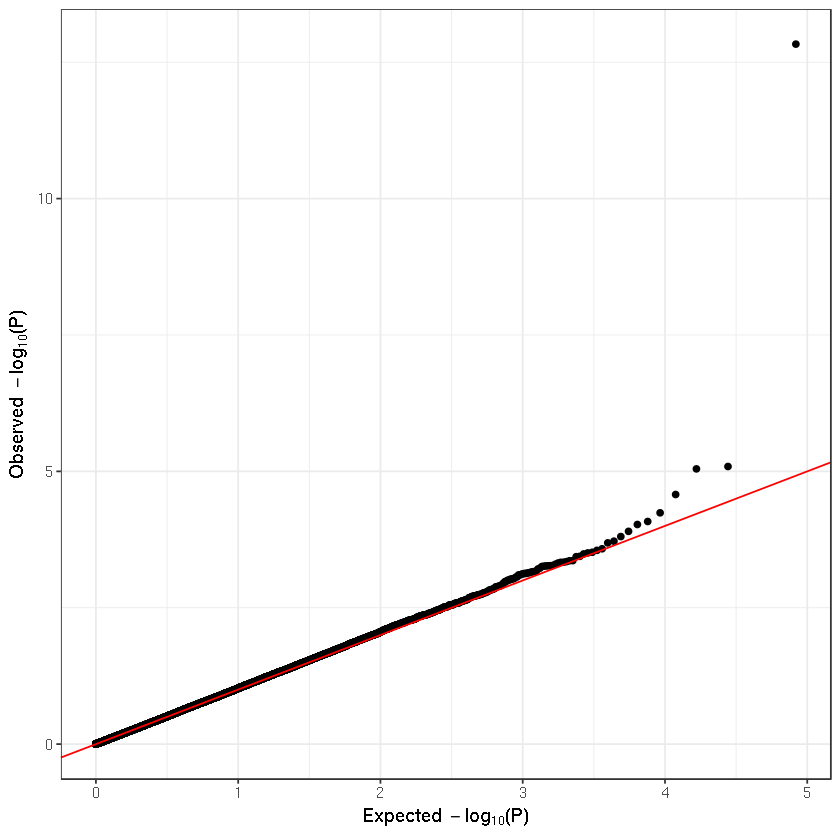

In [14]:
data.frame(
    Observed = qq_p_obs,
    Expected = qq_p_exp
) %>% ggplot(aes(x = Expected, y = Observed)) + geom_point() + 
geom_abline(slope=1, intercept=0, color='red') + 
theme_bw() + 
labs(
    y = TeX('Observed $-\\log_{10}(P)$'),
    x = TeX('Expected $-\\log_{10}(P)$')
) 

In [35]:
ggsave('INI5255.qq.png')

Saving 6.67 x 6.67 in image


In [36]:
0.66 - 1.96 * 0.15

[1] 0.366

In [37]:
0.66 + 1.96 * 0.15

[1] 0.954

In [38]:
0.61 - 1.96 * 0.13

[1] 0.3552

In [39]:
0.61 + 1.96 * 0.13

[1] 0.8648

### Manhattan plot

In [42]:
compute_gwas_plot_df <- function(gwasResults){
    gwasResults  %>%
    # Compute chromosome size
    group_by(CHR) %>% 
    summarise(chr_len=max(BP)) %>% 

    # Calculate cumulative position of each chromosome
    mutate(tot=cumsum(chr_len)-chr_len) %>%
    select(-chr_len) %>%

    # Add this info to the initial dataset
    left_join(gwasResults, ., by=c("CHR"="CHR")) %>%

    # Add a cumulative position of each SNP
    arrange(CHR, BP) %>%
    mutate(BPcum=BP+tot)    
}


In [43]:
compute_x_axis_df <- function(don){
    don %>% 
    group_by(CHR) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(
        CHR_plot = if_else((CHR %% 2) == 0 & (CHR > 15), "", as.character(CHR))
    )    
}


In [87]:
plot_manhattan <- function(don, axisdf, title_str){
    don %>% 
    ggplot( aes(x=BPcum, y=-log10(P), label=repel_label) ) +
    geom_point( aes(color=as.factor(color)), alpha=0.8, size=1.3) +
    geom_hline(yintercept=6, color='red', linetype="dashed") + 
    ggrepel::geom_text_repel(size=3) +
    scale_x_continuous(
        label = axisdf$CHR_plot, breaks= axisdf$center
    ) +
    scale_y_continuous(expand = c(0, 0.5) ) +
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(
        title=title_str,
        x = 'Genomic position (chromosome)',
        y = TeX('$-\\log_{10\\,}P$')
    )    
}


In [55]:
IOP_anno %>% dim()

[1] 113490     42

In [56]:
IOP_anno %>% filter(as.numeric(P) < 1e-2) %>% dim()

[1] 1628   42

In [57]:
0.05 / 113490

[1] 4.405675e-07

In [88]:
IOP_Manhattan_plot_df <- IOP_anno %>% 
mutate(
    is_rare = (MAF <= 0.01)
) %>%
group_by(is_rare) %>%
mutate(rankP = rank(P)) %>%
ungroup() %>%
mutate(
    P = as.numeric(P),
    repel_label = if_else(
        rankP <= 30,
        Gene_symbol, ''
    ), 
    repel_label = if_else(
        P <= 1e-6,
        repel_label, ''
    ),     
    color = 
#     if_else(
#         MAF <= 0.01, '1_rare', 
        if_else(
            (CHROM %% 2) == 1, 
            "2_odd_chrs", "3_even_chrs"
#         )
    )
) %>%
rename(
    CHR = CHROM,
    BP = POS,
    SNP = ID    
) %>%
select(CHR, BP, SNP, P, BETA, repel_label, color, MAF) %>%
compute_gwas_plot_df() %>%
filter(P < 1e-2, MAF <= 0.01)


IOP_Manhattan_p <- IOP_Manhattan_plot_df %>% 
plot_manhattan(
    IOP_Manhattan_plot_df %>% compute_x_axis_df(), ''
)


In [89]:
ggsave('INI5255.manhattan.png', IOP_Manhattan_p)

Saving 6.67 x 6.67 in image
